In [112]:
import tejapi
import os
os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'your key'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipline.sources.TEJ_Api_Data import get_universe
from zipline.data import bundles
from zipline.sources.TEJ_Api_Data import get_Benchmark_Return
from zipline.pipeline.mixins import SingleInputMixin
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.factors import CustomFactor
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline import run_algorithm

In [113]:
pool = get_universe(start = '2018-01-01',
                    end = '2018-08-01',
                    mkt_bd_e = ['TSE'],  # 已上市之股票
                    stktp_e = 'Common Stock'
)
pool

Currently used TEJ API key call quota 296/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 16941841/9223372036854775807 (0.0%)


['1101',
 '1102',
 '1103',
 '1104',
 '1108',
 '1109',
 '1110',
 '1201',
 '1203',
 '1210',
 '1213',
 '1215',
 '1216',
 '1217',
 '1218',
 '1219',
 '1220',
 '1225',
 '1227',
 '1229',
 '1231',
 '1232',
 '1233',
 '1234',
 '1235',
 '1236',
 '1301',
 '1303',
 '1304',
 '1305',
 '1307',
 '1308',
 '1309',
 '1310',
 '1312',
 '1313',
 '1314',
 '1315',
 '1316',
 '1319',
 '1321',
 '1323',
 '1324',
 '1325',
 '1326',
 '1339',
 '1402',
 '1409',
 '1410',
 '1413',
 '1414',
 '1416',
 '1417',
 '1418',
 '1419',
 '1423',
 '1432',
 '1434',
 '1435',
 '1436',
 '1437',
 '1438',
 '1439',
 '1440',
 '1441',
 '1442',
 '1443',
 '1444',
 '1445',
 '1446',
 '1447',
 '1449',
 '1451',
 '1452',
 '1453',
 '1454',
 '1455',
 '1456',
 '1457',
 '1459',
 '1460',
 '1463',
 '1464',
 '1465',
 '1466',
 '1467',
 '1468',
 '1469',
 '1470',
 '1471',
 '1472',
 '1473',
 '1474',
 '1475',
 '1476',
 '1477',
 '1503',
 '1504',
 '1506',
 '1507',
 '1512',
 '1513',
 '1514',
 '1515',
 '1516',
 '1517',
 '1519',
 '1521',
 '1522',
 '1524',
 '1525',
 

In [114]:
import TejToolAPI

cap_data = TejToolAPI.get_history_data(start = '2018-01-03',
                                        end = '2018-01-03',
                                        ticker = pool,
                                        columns = ['Market_Cap_Dollars'])
top_200_cap = cap_data.sort_values(by='Market_Cap_Dollars', ascending=False).head(200)['coid'].tolist()

print(top_200_cap)

Currently used TEJ API key call quota 301/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 17079818/9223372036854775807 (0.0%)
['2330', '2317', '6505', '2412', '2882', '1301', '1303', '1326', '3008', '2881', '2454', '2891', '2002', '1216', '3045', '2308', '2311', '2886', '2912', '2474', '4904', '2382', '2408', '2892', '2357', '5880', '2207', '2884', '4938', '2880', '2303', '2105', '2885', '1101', '2325', '2801', '2883', '2395', '1402', '2887', '2327', '2633', '3481', '2354', '2409', '2823', '9904', '2888', '2890', '2344', '1102', '2301', '2324', '8464', '9910', '2049', '2356', '2227', '1476', '2337', '3532', '2353', '3702', '2377', '2603', '3034', '2347', '6239', '2360', '1227', '2618', '2610', '3231', '1802', '2345', '9921', '2498', '1605', '1504', '2379', '2385', '9945', '2492', '1434', '2834', '2542', '3044', '2448', '2915', '2313', '1909', '2371', '2615', '3682', '2809', '1314', '2352', '9917', '1704', '2439', '6409', '4915', '9914', '1722', '2059', '9938', '2201', 

In [115]:
# start設定為'2018-06-01'，才有辦法算2019-01-01時的動能
start = '2018-06-01'    
end = '2024-08-15'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(top_200_cap) + ' ' + 'IR0001'

!zipline ingest -b tquant

[2024-08-22 03:20:34.410552] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]     
Currently used TEJ API key call quota 359/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 17884333/9223372036854775807 (0.0%)
[2024-08-22 03:20:53.534508] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [116]:
from zipline.pipeline.filters import StaticAssets

class Momentum(CustomFactor):
    inputs = [TWEquityPricing.close]
    # 找不同時間跨度的動能
    window_length = 63
    
    def compute(self, today, assets, out, close):
        
        return_rate = (((close[-1]-close[0])/close[0])*100).round(5)
        
        out[:] = return_rate
    

In [117]:
start = '2019-01-01'
end = '2024-08-15'
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')
bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)
def make_pipeline():
    mom = Momentum()
    curr_price = TWEquityPricing.close.latest
    
    return Pipeline(
        columns = {
        'curr_price': curr_price,
        'Momentum': mom
    },
        screen = ~StaticAssets([benchmark_asset])
    )
my_pipeline = run_pipeline(make_pipeline(), start_dt, end_dt)
dates = my_pipeline.index.get_level_values(0).unique()
my_pipeline

curr_price  Momentum
2019-01-02 00:00:00+00:00 Equity(0 [1101])         35.60 -11.44279
                          Equity(1 [1102])         33.95 -16.17284
                          Equity(2 [1210])         33.50  -9.33694
                          Equity(3 [1216])         69.80 -10.85568
                          Equity(4 [1227])         49.70  -0.40080
...                                                  ...       ...
2024-08-15 00:00:00+00:00 Equity(193 [9933])       48.60   7.00907
                          Equity(194 [9938])       61.30  -7.12540
                          Equity(195 [9940])       33.55   6.91996
                          Equity(196 [9941])      152.00   5.55556
                          Equity(197 [9945])       49.85  10.66674

[266052 rows x 2 columns]

In [118]:
dates

DatetimeIndex(['2019-01-02 00:00:00+00:00', '2019-01-03 00:00:00+00:00',
               '2019-01-04 00:00:00+00:00', '2019-01-07 00:00:00+00:00',
               '2019-01-08 00:00:00+00:00', '2019-01-09 00:00:00+00:00',
               '2019-01-10 00:00:00+00:00', '2019-01-11 00:00:00+00:00',
               '2019-01-14 00:00:00+00:00', '2019-01-15 00:00:00+00:00',
               ...
               '2024-08-02 00:00:00+00:00', '2024-08-05 00:00:00+00:00',
               '2024-08-06 00:00:00+00:00', '2024-08-07 00:00:00+00:00',
               '2024-08-08 00:00:00+00:00', '2024-08-09 00:00:00+00:00',
               '2024-08-12 00:00:00+00:00', '2024-08-13 00:00:00+00:00',
               '2024-08-14 00:00:00+00:00', '2024-08-15 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1365, freq=None)

In [161]:
from zipline.finance import slippage, commission
from zipline.api import *
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order, order_target, symbol, pipeline_output, record

def initialize(context):
    context.holding_stock = False
    context.target = None
    context.stock_buy_price = 0
    set_slippage(slippage.FixedBasisPointsSlippage(basis_points=50.0, volume_limit=1))
    set_commission(commission.PerShare(cost=0.001425 + 0.003 / 2))
    attach_pipeline(make_pipeline(), 'mystrats')
    set_benchmark(symbol('IR0001'))

def handle_data(context, data):
    # Pipeline 輸出表格（例如第一天是2019-01-02，那表格的index會是不同的股票代碼，column和原本的一樣）
    out_dir = pipeline_output('mystrats')

    # 獲得今天日期
    current_date = context.get_datetime()
    current_year = current_date.year
    current_month = current_date.month
    current_day = current_date.day

    # 找到目前日期，在資料裡面這個年月份的第一天和最後一天
    dates_info = dates[(dates.month == current_month) & (dates.year == current_year)]
    min_day = dates_info.min().day
    max_day = dates_info.max().day

    # 每月第一天買入股票
    if not context.holding_stock :
        if current_day == min_day:
            # top_5_momentum = out_dir['Momentum'].nlargest(5)

            # 选择第 5 大的股票
            # context.target = top_5_momentum.index[-1] 
            context.target = out_dir['Momentum'].idxmax()
            context.stock_buy_price = out_dir.loc[(context.target), 'curr_price']
            available_cash = context.portfolio.cash
            num_shares = int(available_cash // context.stock_buy_price)
            order(context.target, num_shares)
            context.holding_stock = True
    # # 若是日期為月底，則出場（也可以設定為：中間如果賠超過5%或超過30%，就先出場）
    elif context.holding_stock:
        stock_price = out_dir.loc[(context.target), 'curr_price']
        # if (current_day != max_day) and ((stock_price - context.stock_buy_price) / context.stock_buy_price) < -0.05:
        #     order_target(context.target, 0)
        #     context.holding_stock = False
        #     context.target = None
        #     context.stock_buy_price = 0
        # if (current_day != max_day) and ((stock_price - context.stock_buy_price) / context.stock_buy_price) > 0.5:
        #     order_target(context.target, 0)
        #     context.holding_stock = False
        #     context.target = None
        #     context.stock_buy_price = 0
        # 每月最後一天賣出持有股票
        if (current_day == max_day):
            order_target(context.target, 0)
            context.holding_stock = False
            context.target = None
            context.stock_buy_price = 0
    else:
        pass

def analyze(context, perf):
    pass

In [162]:
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
results = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=1e7,
    handle_data = handle_data
)

Start date,2019-01-02
End date,2024-08-15
Total months,65
,Backtest
Annual return,64.018%
Cumulative returns,1358.802%
Annual volatility,63.715%
Sharpe ratio,1.09
Calmar ratio,1.21
Stability,0.86
Max drawdown,-52.925%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,52.92,2024-04-09,2024-07-22,NaT,NaN
1,51.57,2019-04-23,2020-03-19,2020-06-10,278
2,48.52,2022-03-23,2022-10-20,2023-02-23,227
3,45.47,2021-01-04,2021-02-02,2021-04-01,56
4,38.36,2021-07-01,2021-07-27,2021-11-09,91


Top 10 long positions of all time,max
sid,
2609,118.50%
3406,115.31%
3443,112.13%
3532,111.04%
2327,110.67%
5269,109.22%
8454,107.93%
3231,107.52%
2201,106.54%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2609,118.50%
3406,115.31%
3443,112.13%
3532,111.04%
2327,110.67%
5269,109.22%
8454,107.93%
3231,107.52%
2201,106.54%


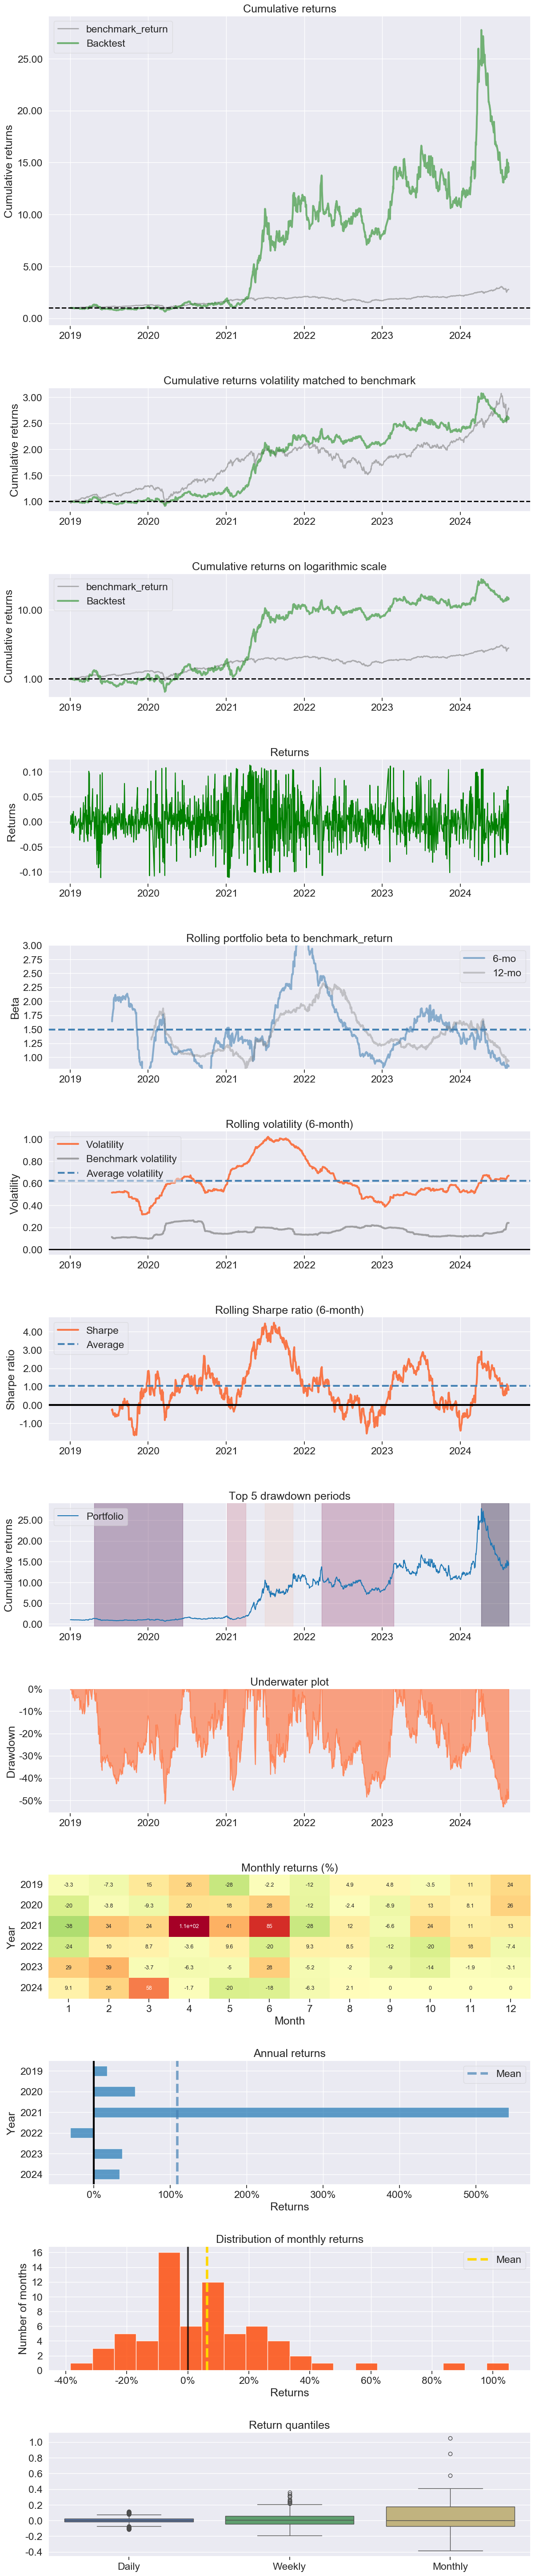

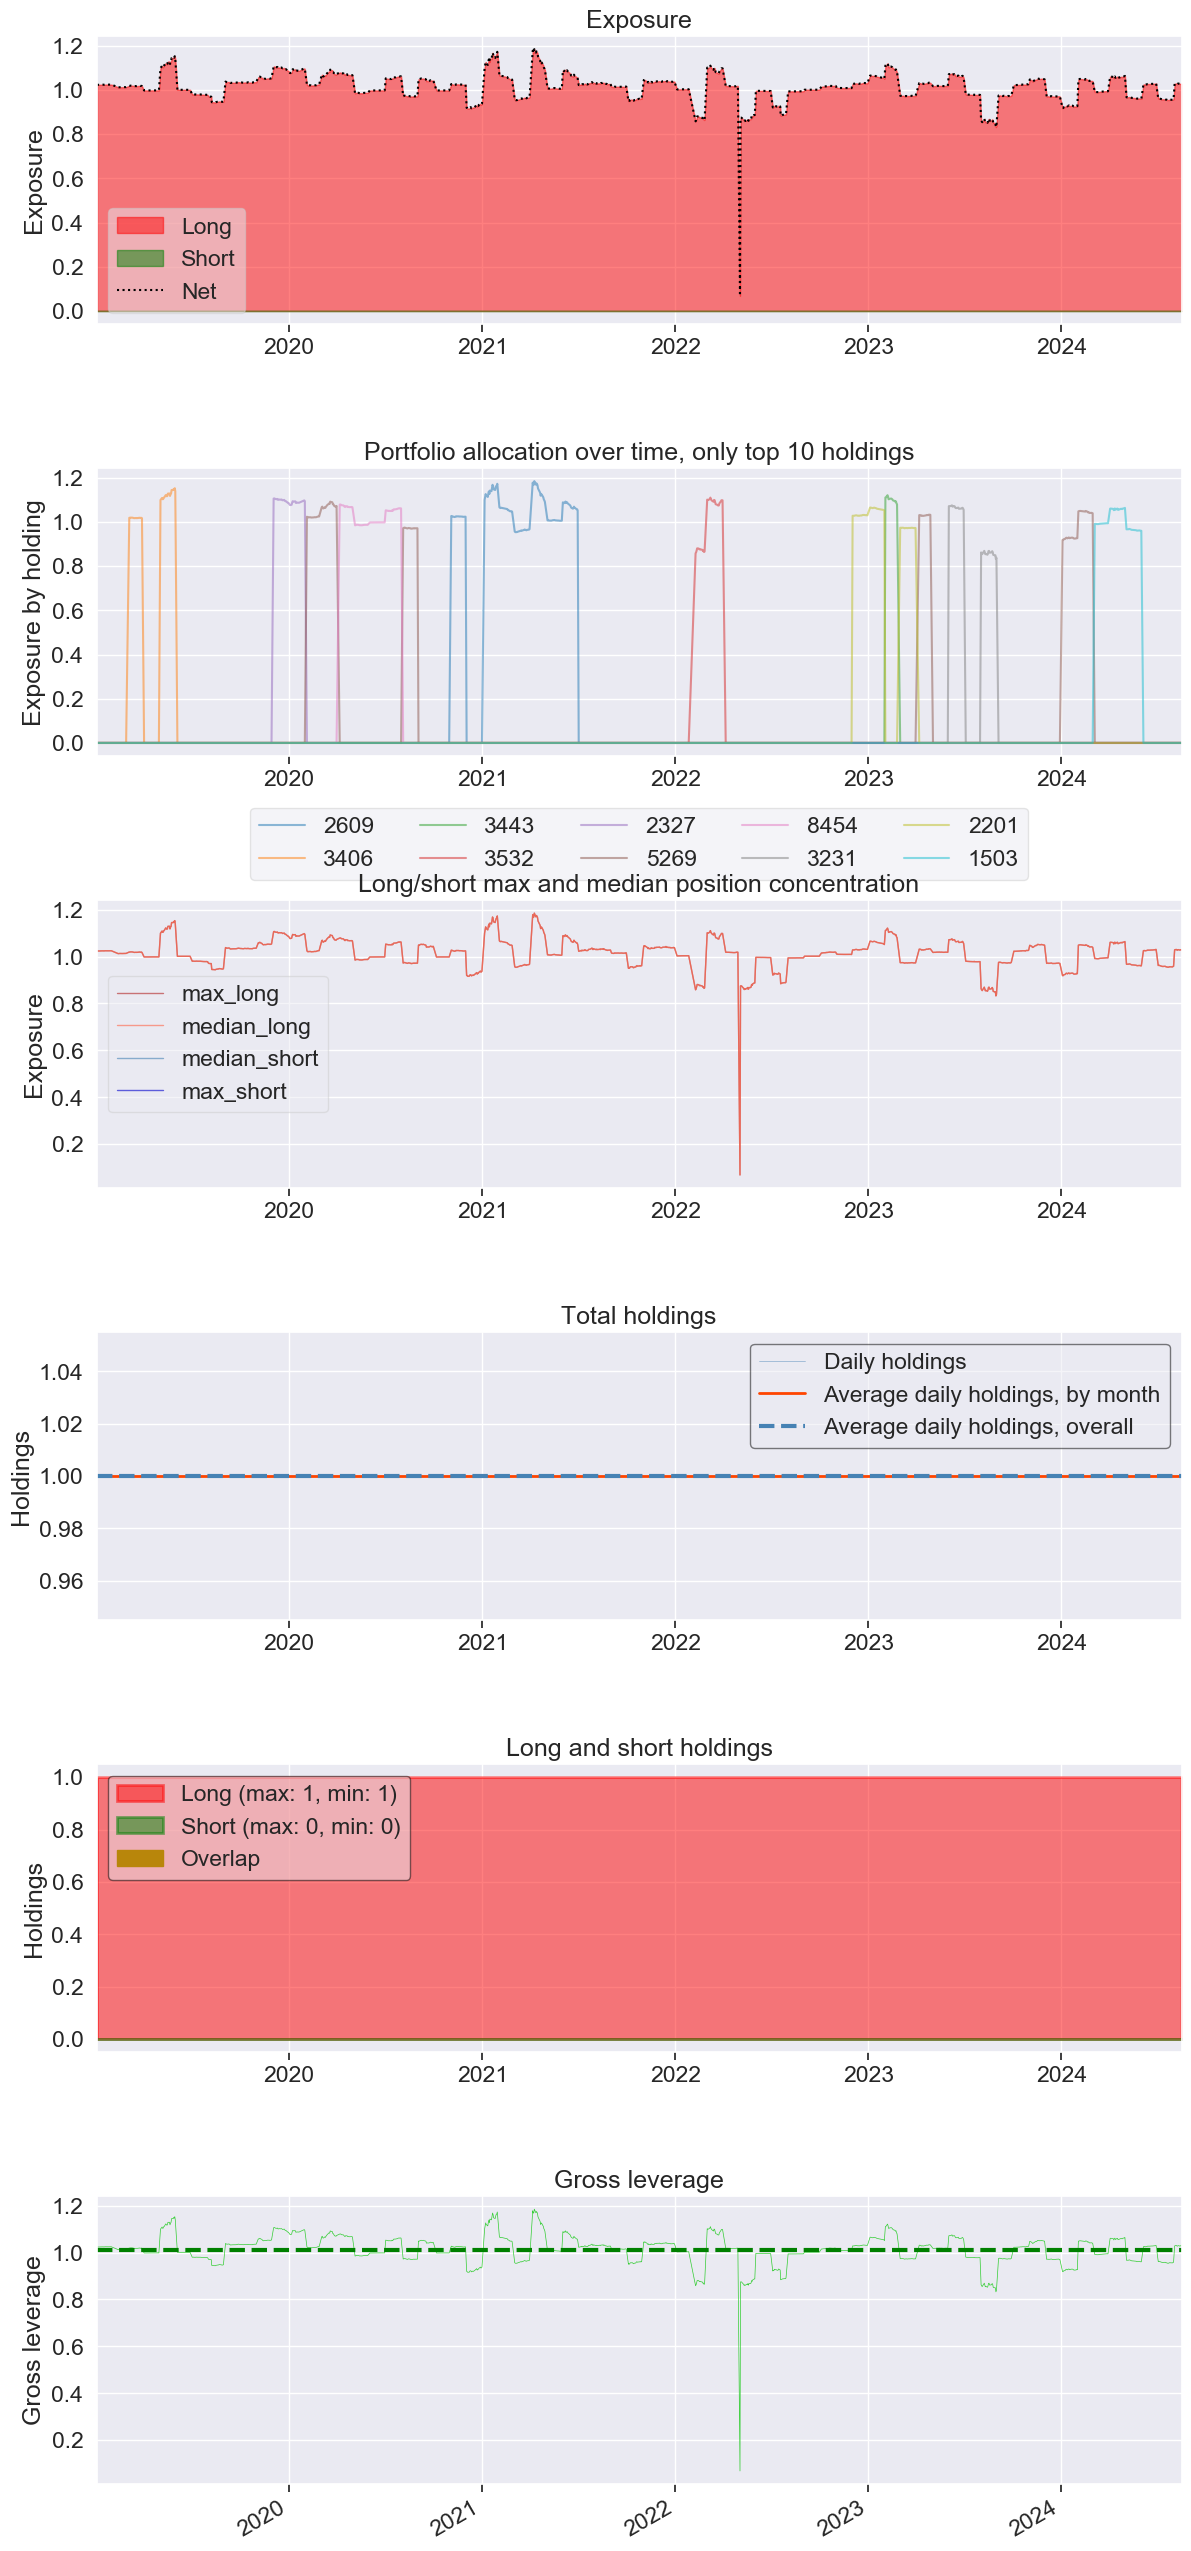

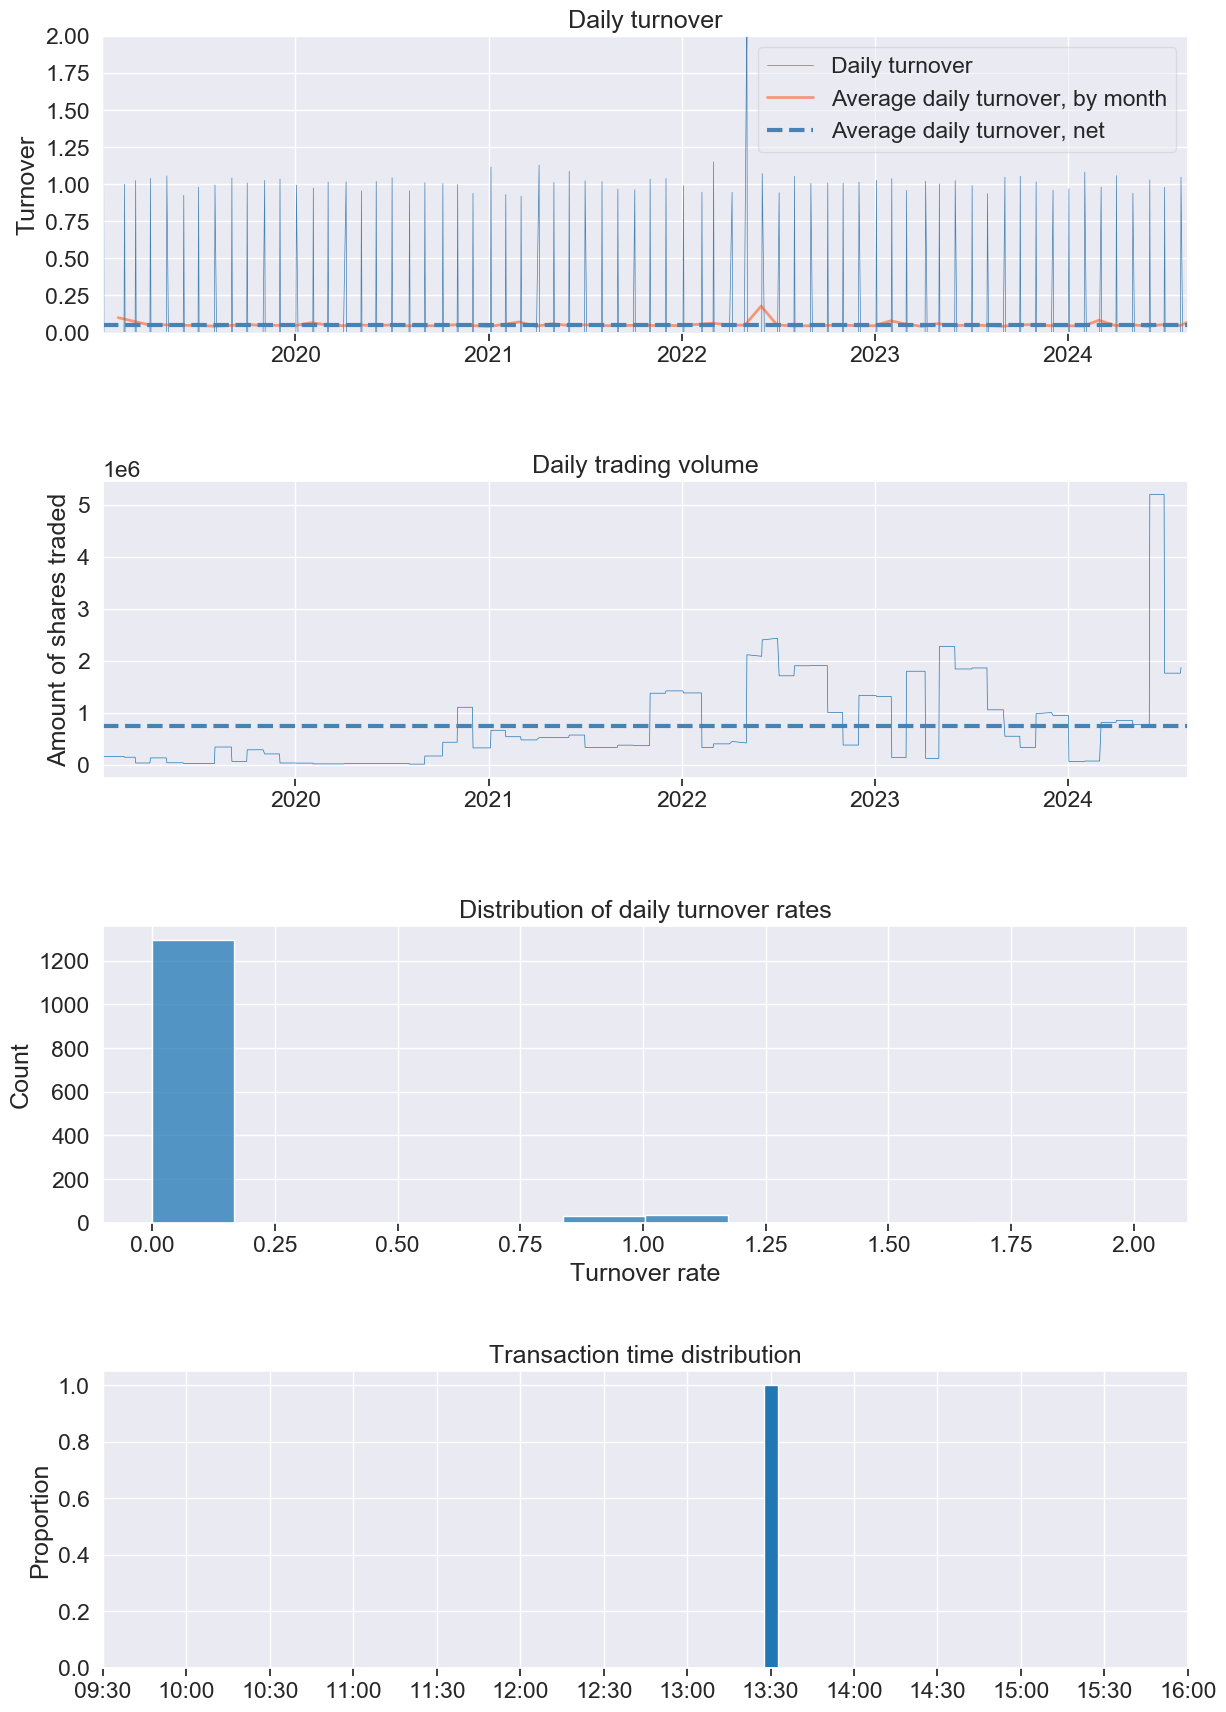

In [163]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import pyfolio as pf
# 從 results 資料表中取出 returns, positions & transactions
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)  # 從 results 資料表中取出 returns, positions & transactions
benchmark_rets = results.benchmark_return  # 取出 benchmark 的報酬率

# 繪製 Pyfolio 中提供的所有圖表
pf.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )

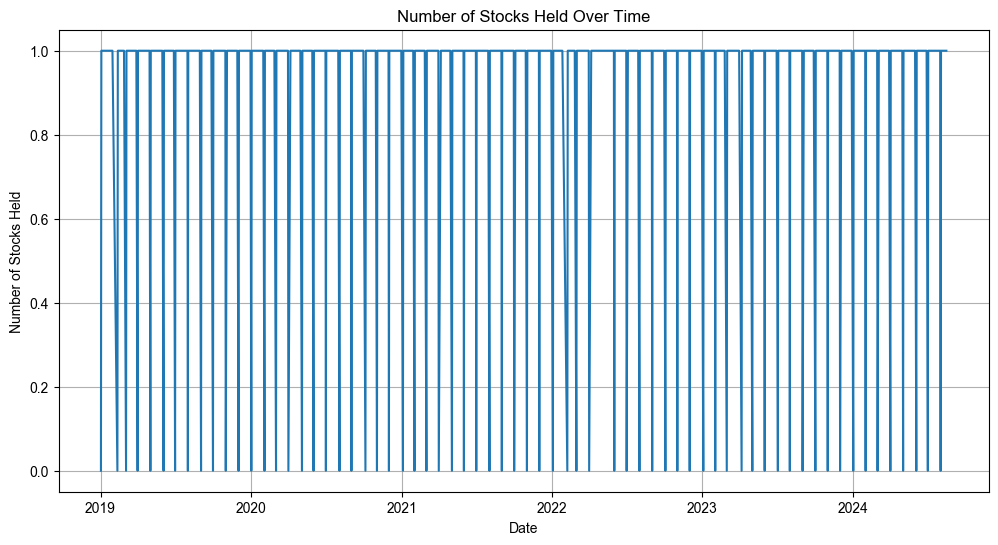

In [164]:
import matplotlib.pyplot as plt

# 提取持倉數據
positions = results['positions']

# 計算每個時間點持有的股票數量
num_holdings = positions.apply(lambda x: len([pos for pos in x if pos['amount'] > 0]))

# 繪製圖表
plt.figure(figsize=(12, 6))
plt.plot(num_holdings.index, num_holdings, label='Number of Holdings')
plt.xlabel('Date')
plt.ylabel('Number of Stocks Held')
plt.title('Number of Stocks Held Over Time')
plt.grid(True)
plt.show()

In [165]:
import pandas as pd

# 假設 `results` 是你的回測結果
positions = results['positions']

# 篩選出 2022 年 1 月到 6 月的持倉數據
positions_2022_first_half = positions.loc['2024-01-01':'2024-07-01']

# 顯示篩選後的表格
positions_2022_first_half_df = pd.DataFrame(positions_2022_first_half)
positions_2022_first_half_df

,positions
2024-01-02 00:00:00+00:00,[]
2024-01-03 00:00:00+00:00,"[{'sid': Equity(164 [5269]), 'amount': 59503, ..."
2024-01-04 00:00:00+00:00,"[{'sid': Equity(164 [5269]), 'amount': 59503, ..."
2024-01-05 00:00:00+00:00,"[{'sid': Equity(164 [5269]), 'amount': 59503, ..."
2024-01-08 00:00:00+00:00,"[{'sid': Equity(164 [5269]), 'amount': 59503, ..."
...,...
2024-06-25 00:00:00+00:00,"[{'sid': Equity(99 [2501]), 'amount': 5198728,..."
2024-06-26 00:00:00+00:00,"[{'sid': Equity(99 [2501]), 'amount': 5198728,..."
2024-06-27 00:00:00+00:00,"[{'sid': Equity(99 [2501]), 'amount': 5198728,..."
2024-06-28 00:00:00+00:00,"[{'sid': Equity(99 [2501]), 'amount': 5198728,..."


In [166]:
import pandas as pd

# 假設 `results` 是你的回測結果
positions = results['positions']

# 創建一個字典來存儲每個股票的進場和出場日期
holdings = {}

# 遍歷每個日期的持倉數據
for date, position in positions.items():
    for stock in position:
        if stock['amount'] > 0:  # 當持有股票
            if stock['sid'] not in holdings:
                # 記錄進場日期
                holdings[stock['sid']] = {'entry': date, 'exit': None}
        else:
            if stock['sid'] in holdings and holdings[stock['sid']]['exit'] is None:
                # 記錄出場日期
                holdings[stock['sid']]['exit'] = date

# 計算持有時間
holdings_period = []
for stock, jj in holdings.items():
    if jj['exit'] is not None:
        holding_period = (jj['exit'] - jj['entry']).days
        holdings_period.append((stock, holding_period))

# 檢查是否有持倉時間超過一個月（30天）
violations = [stock for stock, period in holdings_period if period >= 30]

if violations:
    print(f"以下股票持有時間超過一個月: {violations}")
else:
    print("所有股票持有時間均小於一個月")

所有股票持有時間均小於一個月


In [179]:
def handle_data_with_stop_loss_15percent_and_take_profit_30percent(context, data):
    # Pipeline 輸出表格（例如第一天是2019-01-02，那表格的index會是不同的股票代碼，column和原本的一樣）
    out_dir = pipeline_output('mystrats')

    # 獲得今天日期
    current_date = context.get_datetime()
    current_year = current_date.year
    current_month = current_date.month
    current_day = current_date.day

    # 找到目前日期，在資料裡面這個年月份的第一天和最後一天
    dates_info = dates[(dates.month == current_month) & (dates.year == current_year)]
    min_day = dates_info.min().day
    max_day = dates_info.max().day

    # 每月第一天買入股票
    if not context.holding_stock :
        if current_day == min_day:
            # top_5_momentum = out_dir['Momentum'].nlargest(5)

            # 选择第 5 大的股票
            # context.target = top_5_momentum.index[-1] 
            context.target = out_dir['Momentum'].idxmax()
            context.stock_buy_price = out_dir.loc[(context.target), 'curr_price']
            available_cash = context.portfolio.cash
            num_shares = int(available_cash // context.stock_buy_price)
            order(context.target, num_shares)
            context.holding_stock = True
    # # 若是日期為月底，則出場（也可以設定為：中間如果賠超過5%或超過30%，就先出場）
    elif context.holding_stock:
        stock_price = out_dir.loc[(context.target), 'curr_price']
        if (current_day != max_day) and (((stock_price - context.stock_buy_price) / context.stock_buy_price) < (-0.15)):
            order_target(context.target, 0)
            context.holding_stock = False
            context.target = None
            context.stock_buy_price = 0
        elif (current_day != max_day) and (((stock_price - context.stock_buy_price) / context.stock_buy_price) > (0.3)):
            order_target(context.target, 0)
            context.holding_stock = False
            context.target = None
            context.stock_buy_price = 0
        # 每月最後一天賣出持有股票
        elif (current_day == max_day):
            order_target(context.target, 0)
            context.holding_stock = False
            context.target = None
            context.stock_buy_price = 0
    else:
        pass


def handle_data_with_stop_loss_10percent(context, data):
    # Pipeline 輸出表格（例如第一天是2019-01-02，那表格的index會是不同的股票代碼，column和原本的一樣）
    out_dir = pipeline_output('mystrats')

    # 獲得今天日期
    current_date = context.get_datetime()
    current_year = current_date.year
    current_month = current_date.month
    current_day = current_date.day

    # 找到目前日期，在資料裡面這個年月份的第一天和最後一天
    dates_info = dates[(dates.month == current_month) & (dates.year == current_year)]
    min_day = dates_info.min().day
    max_day = dates_info.max().day

    # 每月第一天買入股票
    if not context.holding_stock :
        if current_day == min_day:
            # top_5_momentum = out_dir['Momentum'].nlargest(5)

            # 选择第 5 大的股票
            # context.target = top_5_momentum.index[-1] 
            context.target = out_dir['Momentum'].idxmax()
            context.stock_buy_price = out_dir.loc[(context.target), 'curr_price']
            available_cash = context.portfolio.cash
            num_shares = int(available_cash // context.stock_buy_price)
            order(context.target, num_shares)
            context.holding_stock = True
    # # 若是日期為月底，則出場（也可以設定為：中間如果賠超過5%或超過30%，就先出場）
    elif context.holding_stock:
        stock_price = out_dir.loc[(context.target), 'curr_price']
        if (current_day != max_day) and (((stock_price - context.stock_buy_price) / context.stock_buy_price) < (-0.1)):
            order_target(context.target, 0)
            context.holding_stock = False
            context.target = None
            context.stock_buy_price = 0
        # if (current_day != max_day) and ((stock_price - context.stock_buy_price) / context.stock_buy_price) > 0.4:
        #     order_target(context.target, 0)
        #     context.holding_stock = False
        #     context.target = None
        #     context.stock_buy_price = 0
        # 每月最後一天賣出持有股票
        elif (current_day == max_day):
            order_target(context.target, 0)
            context.holding_stock = False
            context.target = None
            context.stock_buy_price = 0
    else:
        pass

def handle_data_with_stop_loss_15percent(context, data):
    # Pipeline 輸出表格
    out_dir = pipeline_output('mystrats')

    # 獲得今天日期
    current_date = context.get_datetime()
    current_year = current_date.year
    current_month = current_date.month
    current_day = current_date.day

    # 找到目前日期，在資料裡面這個年月份的第一天和最後一天
    dates_info = dates[(dates.month == current_month) & (dates.year == current_year)]
    min_day = dates_info.min().day
    max_day = dates_info.max().day

    # 每月第一天買入股票
    if not context.holding_stock:
        if current_day == min_day:
            context.target = out_dir['Momentum'].idxmax()
            context.stock_buy_price = out_dir.loc[context.target, 'curr_price']
            available_cash = context.portfolio.cash
            num_shares = int(available_cash // context.stock_buy_price)
            order(context.target, num_shares)
            context.holding_stock = True

    elif context.holding_stock:
        stock_price = out_dir.loc[context.target, 'curr_price']

        # 止損條件判斷
        if (((stock_price - context.stock_buy_price) / context.stock_buy_price) < (-0.15)):
            order_target(context.target, 0)
            context.holding_stock = False
            context.target = None
            context.stock_buy_price = 0

        # 每月最後一天賣出持有股票
        elif current_day == max_day:
            order_target(context.target, 0)
            context.holding_stock = False
            context.target = None
            context.stock_buy_price = 0

def analyze(context, perf):
    pass

results_with_stop_loss_15percent_and_take_profit_30percent = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=1e7,
    handle_data = handle_data_with_stop_loss_15percent_and_take_profit_30percent
)

results_with_stop_loss_10percent = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=1e7,
    handle_data = handle_data_with_stop_loss_10percent
)

results_with_stop_loss_15percent = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=1e7,
    handle_data = handle_data_with_stop_loss_15percent
)



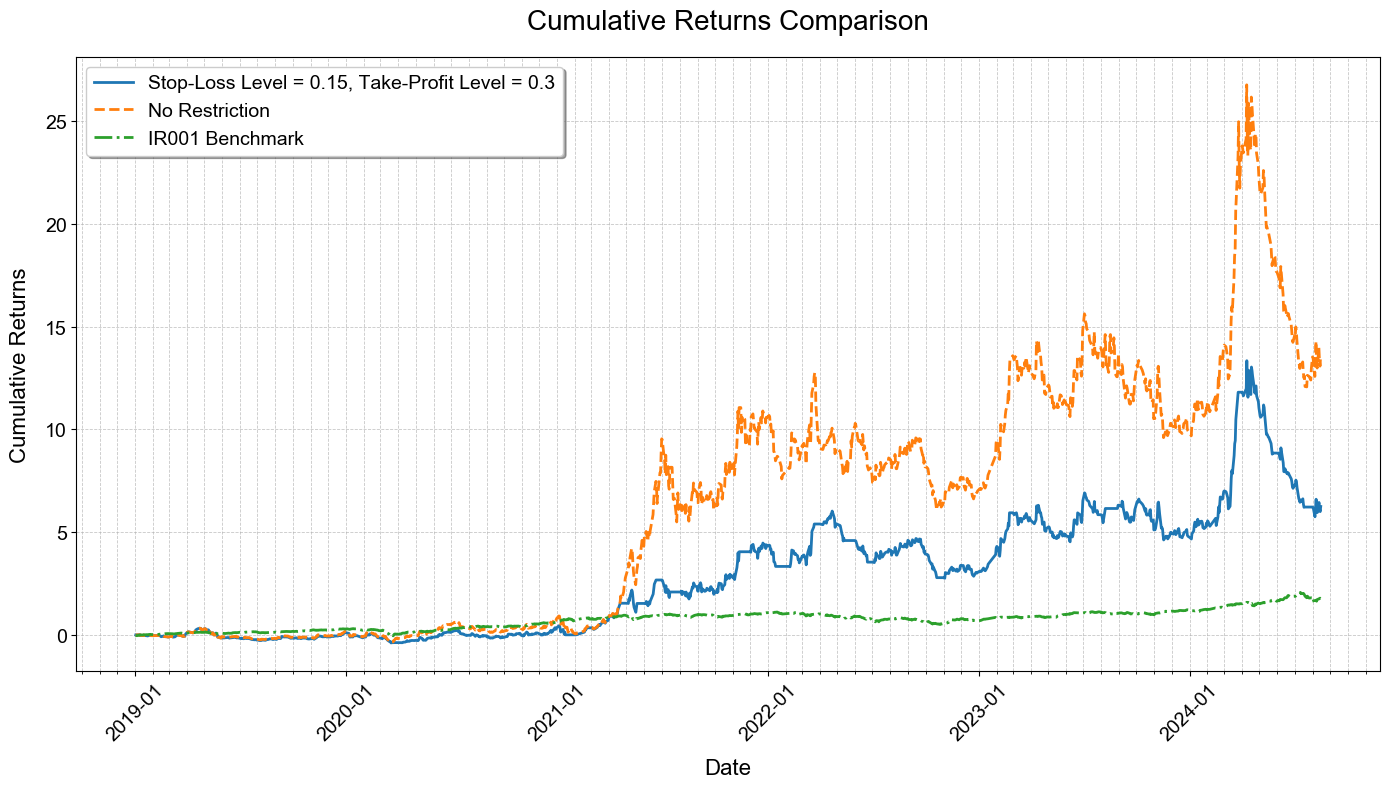

In [180]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 計算累積報酬率
cum_returns_with_stop_loss_15percent_and_take_profit_30percent = (1 + results_with_stop_loss_15percent_and_take_profit_30percent['returns']).cumprod() - 1
# cum_returns_with_stop_loss_15percent = (1 + results_with_stop_loss_15percent['returns']).cumprod() - 1
cum_returns_without_any_restriction = (1 + results['returns']).cumprod() - 1
IR001_profit = results['benchmark_period_return']  # 假設這是累積報酬

# 繪製圖表
plt.figure(figsize=(14, 8))

# 畫出各條曲線
plt.plot(cum_returns_with_stop_loss_15percent_and_take_profit_30percent, label='Stop-Loss Level = 0.15, Take-Profit Level = 0.3', color='#1f77b4', linestyle='-', linewidth=2)
# plt.plot(cum_returns_with_stop_loss_15percent, label='Stop-Loss Level = 0.15', color='#d62728', linestyle='-', linewidth=2)
plt.plot(cum_returns_without_any_restriction, label='No Restriction', color='#ff7f0e', linestyle='--', linewidth=2)
plt.plot(IR001_profit, label='IR001 Benchmark', color='#2ca02c', linestyle='-.', linewidth=2)

# 設置標題和標籤
plt.title('Cumulative Returns Comparison', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=16, labelpad=10)
plt.ylabel('Cumulative Returns', fontsize=16, labelpad=10)

# 添加網格和標籤
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)

# 調整日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# 調整刻度字體
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

# 添加圖例
plt.legend(fontsize=14, loc='upper left', shadow=True, fancybox=True)

# 顯示圖表
plt.tight_layout()
plt.show()

Start date,2019-01-02
End date,2024-08-15
Total months,65
,Backtest
Annual return,39.958%
Cumulative returns,517.75%
Annual volatility,54.891%
Sharpe ratio,0.88
Calmar ratio,0.75
Stability,0.82
Max drawdown,-52.963%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,52.96,2022-03-23,2022-11-03,2023-06-30,310
1,50.22,2023-07-03,2024-08-05,NaT,NaN
2,39.51,2019-12-31,2020-03-17,2020-06-17,110
3,33.93,2021-05-10,2021-05-17,2021-06-17,28
4,30.37,2019-04-23,2019-08-05,2019-12-30,173


Top 10 long positions of all time,max
sid,
2609,118.50%
3406,112.91%
3443,112.13%
3532,111.04%
2327,110.67%
5269,108.41%
8454,107.93%
3231,107.52%
2201,106.54%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2609,118.50%
3406,112.91%
3443,112.13%
3532,111.04%
2327,110.67%
5269,108.41%
8454,107.93%
3231,107.52%
2201,106.54%


,period_open,period_close,long_exposure,returns,ending_exposure,orders,ending_cash,positions,short_exposure,pnl,...,alpha,beta,benchmark_period_return,excess_return,benchmark_volatility,trading_days,algo_volatility,max_drawdown,treasury_period_return,period_label
2019-01-02 00:00:00+00:00,2019-01-02 09:01:00+08:00,2019-01-02 13:30:00+08:00,0.0,0.000000,0.0,"[{'id': 'a418f44bc37c4119adc0ec788d596d4c', 'd...",1.000000e+07,[],0.0,0.000000e+00,...,NaN,NaN,-0.017812,0.017812,NaN,1,NaN,0.000000,0.0,2019-01
2019-01-03 00:00:00+00:00,2019-01-03 09:01:00+08:00,2019-01-03 13:30:00+08:00,10186900.2,-0.005139,10186900.2,"[{'id': 'a418f44bc37c4119adc0ec788d596d4c', 'd...",-2.382903e+05,"[{'sid': Equity(165 [5388]), 'amount': 155763,...",0.0,-5.139011e+04,...,-0.869995,-0.452687,-0.024157,0.019018,0.127429,2,0.057685,-0.005139,0.0,2019-01
2019-01-04 00:00:00+00:00,2019-01-04 09:01:00+08:00,2019-01-04 13:30:00+08:00,10311510.6,0.012525,10311510.6,[],-2.382903e+05,"[{'sid': Equity(165 [5388]), 'amount': 155763,...",0.0,1.246104e+05,...,-0.379777,-0.364503,-0.035456,0.042778,0.090250,3,0.144235,-0.005139,0.0,2019-01
2019-01-07 00:00:00+00:00,2019-01-07 09:01:00+08:00,2019-01-07 13:30:00+08:00,10327086.9,0.001546,10327086.9,[],-2.382903e+05,"[{'sid': Equity(165 [5388]), 'amount': 155763,...",0.0,1.557630e+04,...,0.680203,-0.050165,-0.014095,0.022975,0.280484,4,0.117992,-0.005139,0.0,2019-01
2019-01-08 00:00:00+00:00,2019-01-08 09:01:00+08:00,2019-01-08 13:30:00+08:00,10311510.6,-0.001544,10311510.6,[],-2.382903e+05,"[{'sid': Equity(165 [5388]), 'amount': 155763,...",0.0,-1.557630e+04,...,0.389281,-0.052217,-0.016840,0.024162,0.242949,5,0.105643,-0.005139,0.0,2019-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-09 00:00:00+00:00,2024-08-09 09:01:00+08:00,2024-08-09 13:30:00+08:00,60986070.0,-0.020888,60986070.0,[],-1.738998e+06,"[{'sid': Equity(107 [2615]), 'amount': 789975,...",0.0,-1.263960e+06,...,0.332563,0.953343,1.719585,3.205122,0.175725,1361,0.548328,-0.529631,0.0,2024-08
2024-08-12 00:00:00+00:00,2024-08-12 09:01:00+08:00,2024-08-12 13:30:00+08:00,65172937.5,0.070668,65172937.5,[],-1.738998e+06,"[{'sid': Equity(107 [2615]), 'amount': 789975,...",0.0,4.186868e+06,...,0.345193,0.957839,1.758218,3.585176,0.175755,1362,0.548925,-0.529631,0.0,2024-08
2024-08-13 00:00:00+00:00,2024-08-13 09:01:00+08:00,2024-08-13 13:30:00+08:00,62487022.5,-0.042342,62487022.5,[],-1.738998e+06,"[{'sid': Equity(107 [2615]), 'amount': 789975,...",0.0,-2.685915e+06,...,0.334149,0.957699,1.761886,3.312916,0.175691,1363,0.549053,-0.529631,0.0,2024-08
2024-08-14 00:00:00+00:00,2024-08-14 09:01:00+08:00,2024-08-14 13:30:00+08:00,61381057.5,-0.018206,61381057.5,[],-1.738998e+06,"[{'sid': Equity(107 [2615]), 'amount': 789975,...",0.0,-1.105965e+06,...,0.327353,0.955937,1.791542,3.172664,0.175678,1364,0.548920,-0.529631,0.0,2024-08


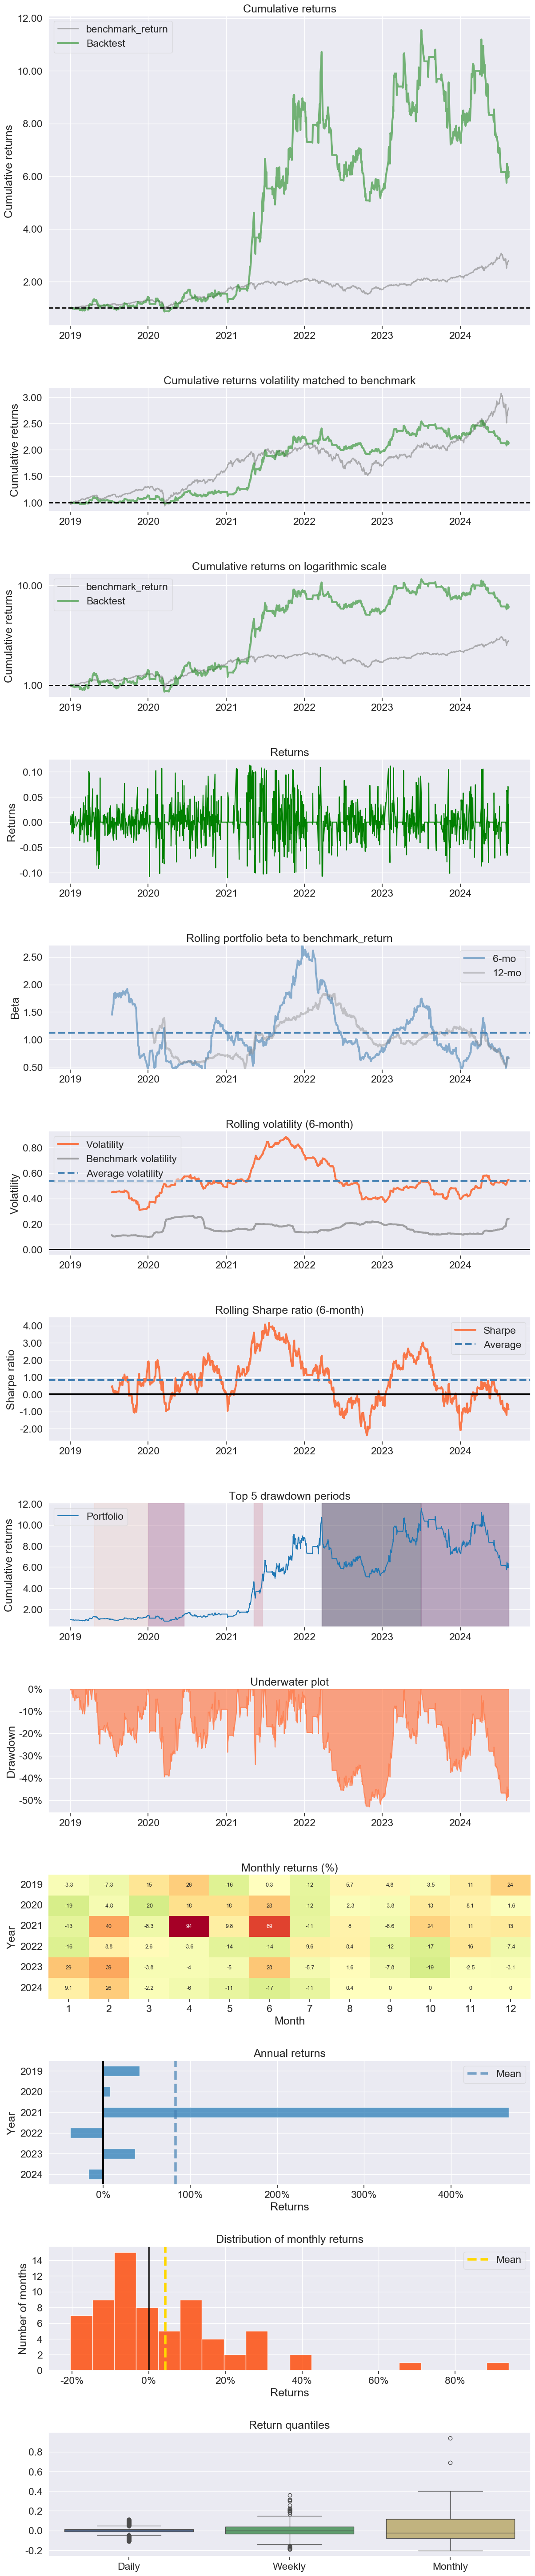

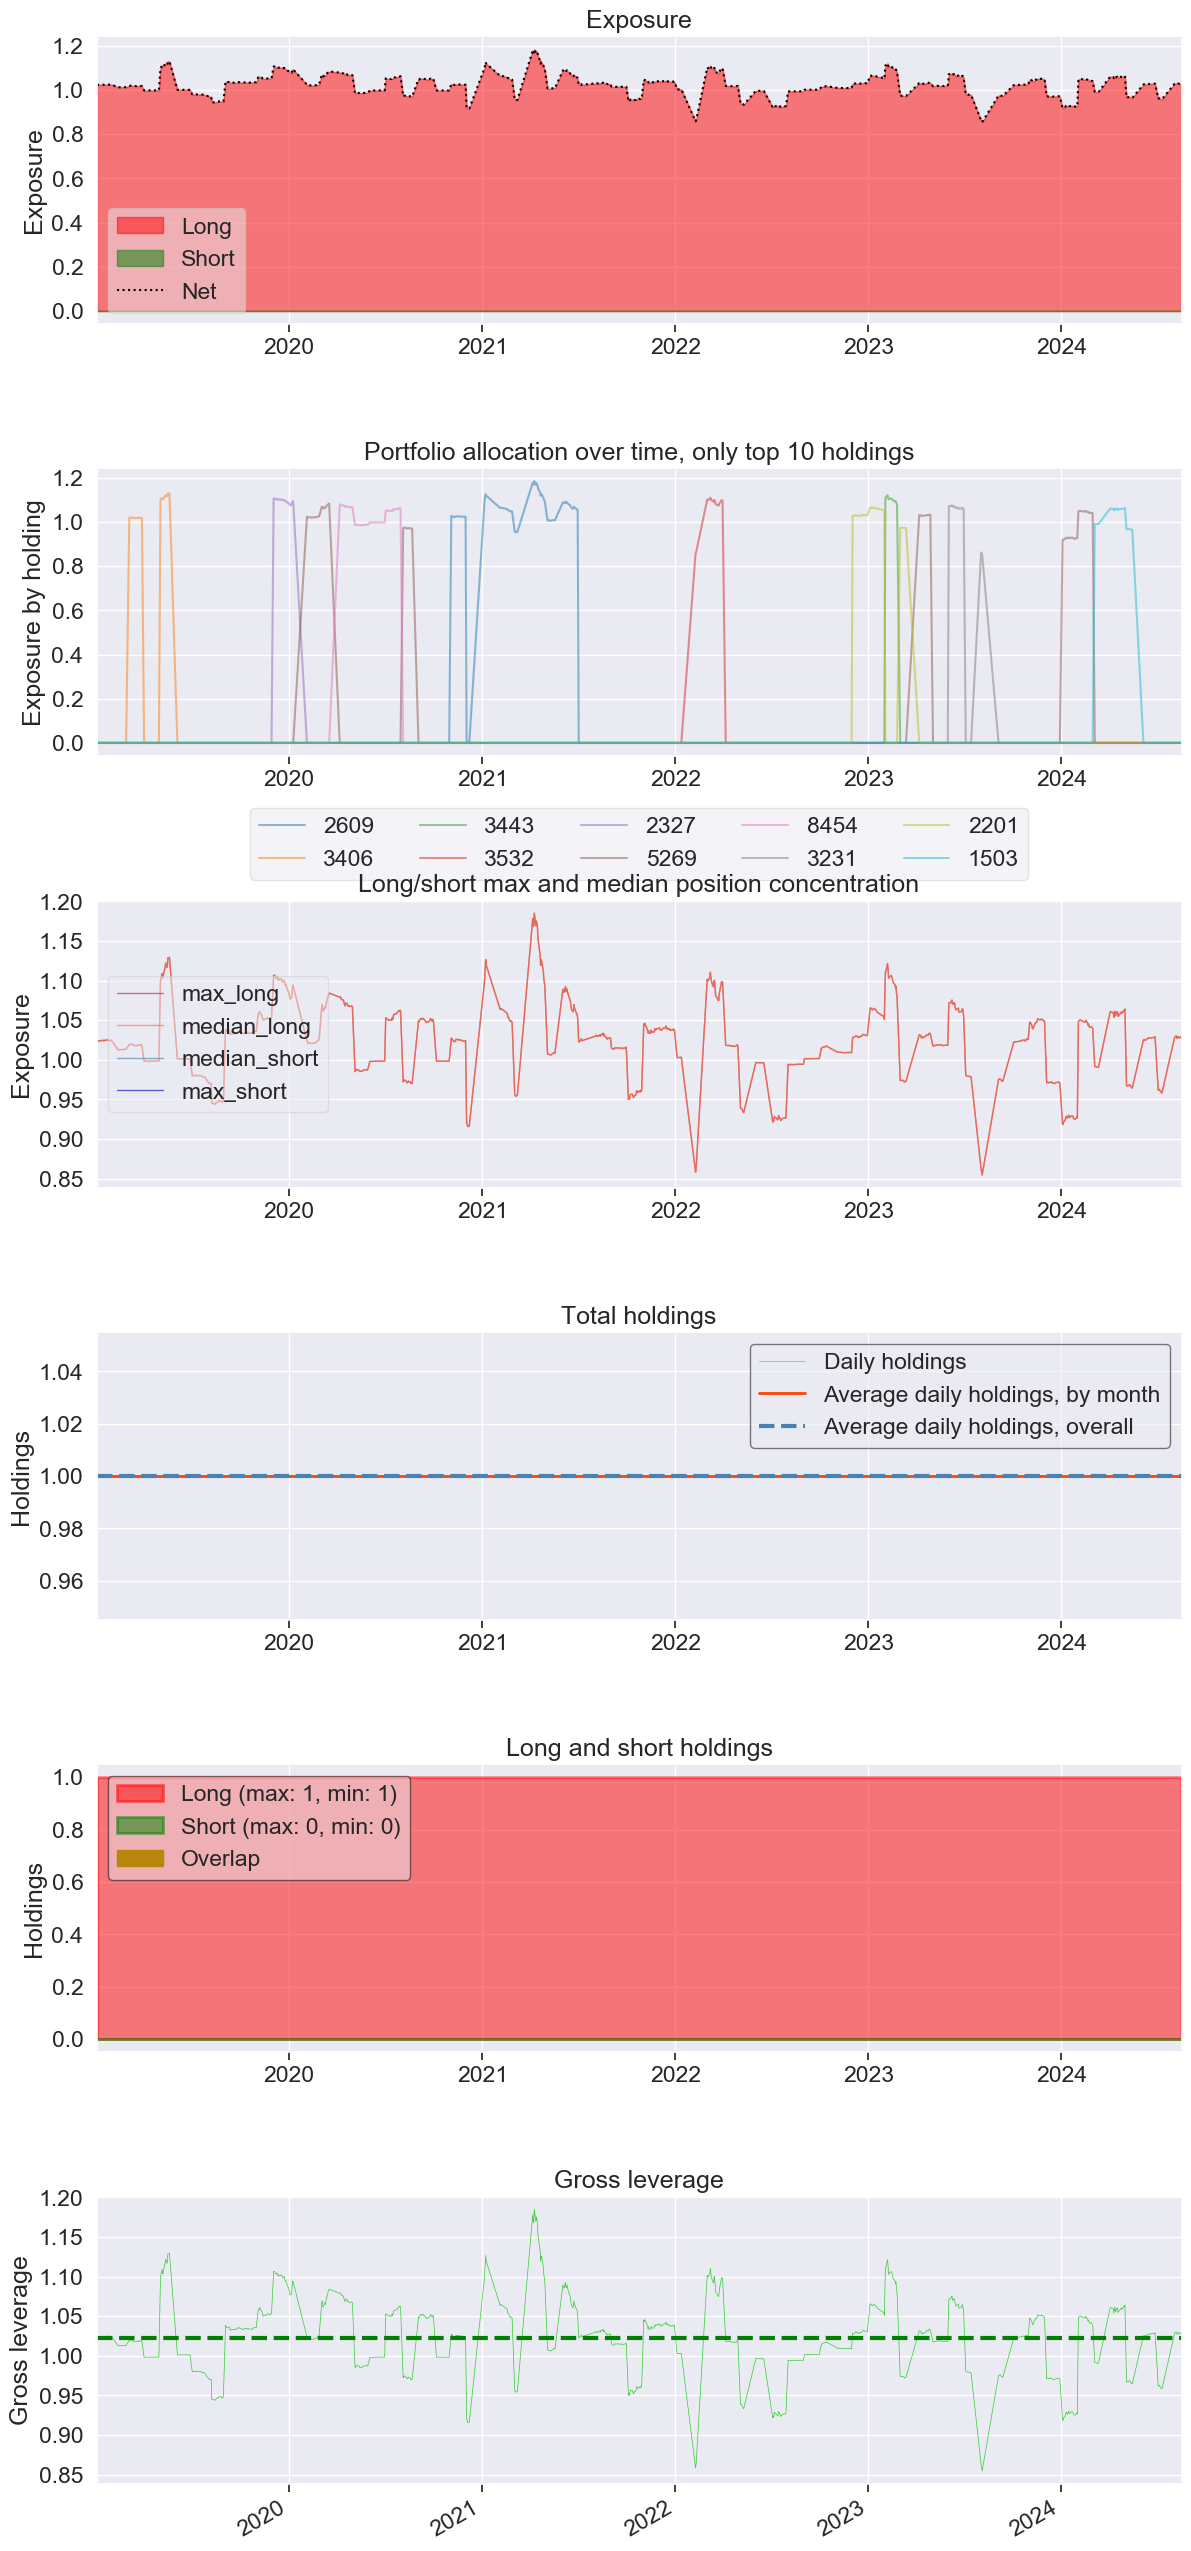

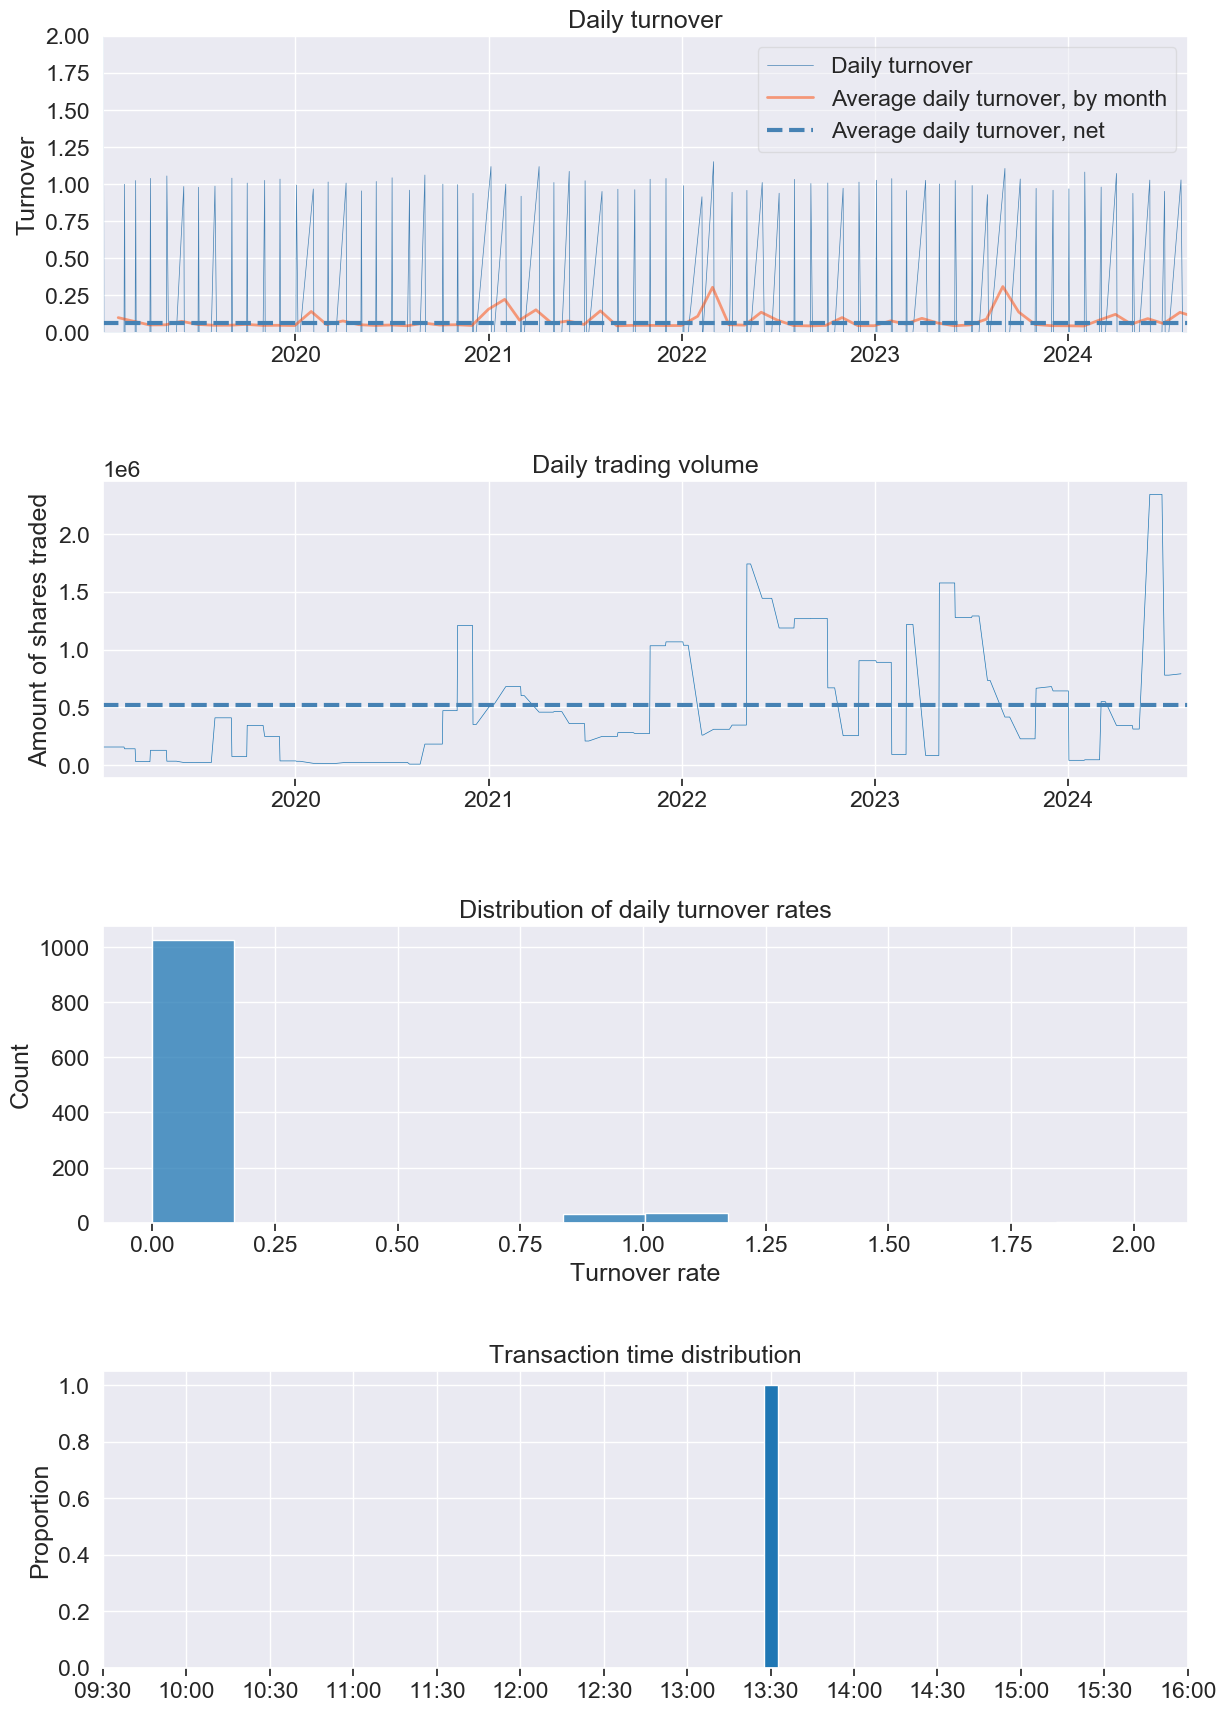

In [181]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results_with_stop_loss_10percent)  # 從 results 資料表中取出 returns, positions & transactions
benchmark_rets = results_with_stop_loss_10percent.benchmark_return  # 取出 benchmark 的報酬率

# 繪製 Pyfolio 中提供的所有圖表
pf.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )
results_with_stop_loss_10percent

In [182]:
# 篩選出 2024 年期間的持倉資料
positions_5percent = results_with_stop_loss_5percent.loc['2024', 'positions']
positions_10percent = results_with_stop_loss_10percent.loc['2024', 'positions']
positions_no_restriction = results.loc['2024', 'positions']

# 提取持有的股票代碼
stocks_held_5percent = set([position['sid'] for positions_list in positions_5percent for position in positions_list])
stocks_held_10percent = set([position['sid'] for positions_list in positions_10percent for position in positions_list])
stocks_held_no_restriction = set([position['sid'] for positions_list in positions_no_restriction for position in positions_list])

# 打印持有的股票代碼
print("策略：止損 5% 持有的股票:", stocks_held_5percent)
print("策略：止損 10% 持有的股票:", stocks_held_10percent)
print("策略：無限制策略持有的股票:", stocks_held_no_restriction)

策略：止損 5% 持有的股票: {Equity(99 [2501]), Equity(107 [2615]), Equity(19 [1503]), Equity(164 [5269])}
策略：止損 10% 持有的股票: {Equity(99 [2501]), Equity(107 [2615]), Equity(19 [1503]), Equity(164 [5269])}
策略：無限制策略持有的股票: {Equity(99 [2501]), Equity(107 [2615]), Equity(19 [1503]), Equity(164 [5269])}


In [183]:
# 篩選出 2024 年期間的持倉資料
positions_5percent = results_with_stop_loss_5percent.loc['2024', 'positions']
positions_10percent = results_with_stop_loss_10percent.loc['2024', 'positions']
positions_no_restriction = results.loc['2024', 'positions']

# 提取持有的股票代碼
stocks_held_5percent = set([position['sid'] for positions_list in positions_5percent for position in positions_list])
stocks_held_10percent = set([position['sid'] for positions_list in positions_10percent for position in positions_list])
stocks_held_no_restriction = set([position['sid'] for positions_list in positions_no_restriction for position in positions_list])

# 打印持有的股票代碼
print("策略：止損 5% 持有的股票:", stocks_held_5percent)
print("策略：止損 10% 持有的股票:", stocks_held_10percent)
print("策略：無限制策略持有的股票:", stocks_held_no_restriction)

策略：止損 5% 持有的股票: {Equity(99 [2501]), Equity(107 [2615]), Equity(19 [1503]), Equity(164 [5269])}
策略：止損 10% 持有的股票: {Equity(99 [2501]), Equity(107 [2615]), Equity(19 [1503]), Equity(164 [5269])}
策略：無限制策略持有的股票: {Equity(99 [2501]), Equity(107 [2615]), Equity(19 [1503]), Equity(164 [5269])}


In [184]:
import pandas as pd

# 假設 my_pipeline 已經包含每日股價數據
# 我們想提取股票代碼為 107 [2615] 的數據

# 首先，確認 my_pipeline 中有包含股價的數據，並且索引是日期加股票代碼
# 假設 my_pipeline 的索引是 (日期, 股票代碼)，並且有一列是 'close' 表示收盤價

# 提取 2024 年 2 月到 3 月期間股票代碼為 107 [2615] 的股價數據
equity_prices = my_pipeline.loc[
    (slice('2024-02-01', '2024-03-30'), 19),  # 篩選日期範圍和股票代碼
    'curr_price'  # 篩選我們關心的列，這裡假設是收盤價
]

# 打印股價數據
print(equity_prices)

2024-02-01 00:00:00+00:00  Equity(19 [1503])    121.5
2024-02-02 00:00:00+00:00  Equity(19 [1503])    131.0
2024-02-05 00:00:00+00:00  Equity(19 [1503])    124.5
2024-02-15 00:00:00+00:00  Equity(19 [1503])    122.0
2024-02-16 00:00:00+00:00  Equity(19 [1503])    125.0
2024-02-19 00:00:00+00:00  Equity(19 [1503])    137.5
2024-02-20 00:00:00+00:00  Equity(19 [1503])    148.5
2024-02-21 00:00:00+00:00  Equity(19 [1503])    146.5
2024-02-22 00:00:00+00:00  Equity(19 [1503])    161.0
2024-02-23 00:00:00+00:00  Equity(19 [1503])    172.0
2024-02-26 00:00:00+00:00  Equity(19 [1503])    174.0
2024-02-27 00:00:00+00:00  Equity(19 [1503])    175.5
2024-02-29 00:00:00+00:00  Equity(19 [1503])    171.5
2024-03-01 00:00:00+00:00  Equity(19 [1503])    187.0
2024-03-04 00:00:00+00:00  Equity(19 [1503])    184.0
2024-03-05 00:00:00+00:00  Equity(19 [1503])    184.5
2024-03-06 00:00:00+00:00  Equity(19 [1503])    182.5
2024-03-07 00:00:00+00:00  Equity(19 [1503])    180.0
2024-03-08 00:00:00+00:00  E